In [ ]:
# import libraries

import os
import random

import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# data extraction, EDA, cleaning phase

In [ ]:
# download dataset from facebook AI public files
!wget "https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz"

--2022-09-22 16:01:56--  https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28022709 (27M) [application/gzip]
Saving to: ‘empatheticdialogues.tar.gz’

empatheticdialogues 100%[===================>]  26.72M  9.73MB/s    in 2.7s    

2022-09-22 16:02:00 (9.73 MB/s) - ‘empatheticdialogues.tar.gz’ saved [28022709/28022709]



In [ ]:
# unzip test, train, and valid files
!tar -xvf empatheticdialogues.tar.gz

empatheticdialogues/
empatheticdialogues/test.csv
empatheticdialogues/train.csv
empatheticdialogues/valid.csv


In [ ]:
# load train csv file 
splitname = "train"
path = '/content/empatheticdialogues'

# create variable for training dataset
train_df = open(os.path.join(path, f"{splitname}.csv")).readlines()
# index 0 is the column names for the dataset
print(train_df[0].strip().split(","))
print(train_df[1].strip().split(","))
print(train_df[2].strip().split(","))
print(type(train_df))

['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags']
['hit:0_conv:1', '1', 'sentimental', 'I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.', '1', 'I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world.', '5|5|5_2|2|5', '']
['hit:0_conv:1', '2', 'sentimental', 'I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.', '0', 'Was this a friend you were in love with_comma_ or just a best friend?', '5|5|5_2|2|5', '']
<class 'list'>


In [ ]:
# load the prompt (message), and context (mood/emotion/label) from the training data into their own arrays
raw_train_prompt_list = []
raw_train_context_list = []

for i in range(1, len(train_df)):
  data_line = train_df[i].strip().split(",")
  raw_train_context_list.append(data_line[2])
  raw_train_prompt_list.append(data_line[3].replace("_comma_", ","))

In [ ]:
# create pandas training dataframe using arrays
train_dataframe = pd.DataFrame(columns=['prompt','context'])
train_dataframe['prompt'] = raw_train_prompt_list
train_dataframe['context'] = raw_train_context_list
print(f"There are {len(train_dataframe)} rows in the training dataset.")
train_dataframe.head()

There are 84169 rows in the training dataset.


,prompt,context
0,I remember going to the fireworks with my best...,sentimental
1,I remember going to the fireworks with my best...,sentimental
2,I remember going to the fireworks with my best...,sentimental
3,I remember going to the fireworks with my best...,sentimental
4,I remember going to the fireworks with my best...,sentimental


In [ ]:
total_duplicate_train = sum(train_dataframe[['prompt','context']].duplicated())
print(f"There are {total_duplicate_train} duplicate prompts (messages) to context (emotion) rows in the training data.")

There are 64862 duplicate prompts (messages) to context (emotion) rows in the training data.


In [ ]:
# If we remove duplicates there will be 19307 rows of training data
84169-64862

19307

In [ ]:
# lets drop duplicate enteries of prompts, context
train_dataframe = train_dataframe.drop_duplicates(ignore_index=True)
train_dataframe.shape

(19307, 2)

In [ ]:
# display random message from train data frame with accompying sentiment
idx = np.random.randint(train_dataframe.shape[0])
print('Train DF row is: ', idx)
print('Message: ', train_dataframe['prompt'].iloc[idx])
print('Sentiment: ', train_dataframe['context'].iloc[idx])

Train DF row is:  6724
Message:  i found a pyrex bowl like one my mom used to have
Sentiment:  nostalgic


In [ ]:
print(train_dataframe['context'].value_counts())

surprised       1000
excited          740
angry            686
proud            670
sad              664
annoyed          662
grateful         638
lonely           634
afraid           626
terrified        618
impressed        617
hopeful          616
disgusted        614
guilty           613
anxious          612
confident        611
anticipating     599
furious          599
joyful           598
nostalgic        597
disappointed     595
prepared         589
jealous          579
content          570
embarrassed      560
devastated       557
sentimental      515
caring           504
trusting         499
ashamed          490
apprehensive     462
faithful         373
Name: context, dtype: int64


In [ ]:
train_dataframe['context'].value_counts().shape

(32,)

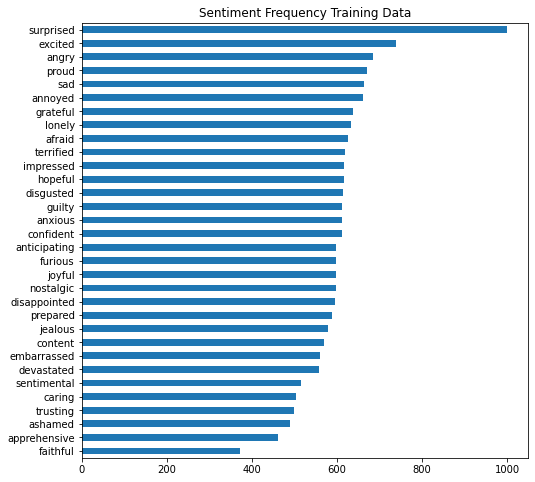

In [ ]:
# visualize value counts of sentiments of train data using horizontal bar plot 
train_dataframe.context.value_counts().sort_values().plot(kind = 'barh', linewidth=20, figsize = [8,8], title='Sentiment Frequency Training Data')

In [ ]:
# divide the total number of emotions together into 8 groups by grouping 
# sourced from sentiment analysis research paper
# https://arxiv.org/ftp/arxiv/papers/2204/2204.11320.pdf

# create a function which groups similar sentiments together
def emotion_grouping(df_column):
  excited_list = ['excited', 'surprised', 'joyful']
  afraid_list = ['afraid', 'terrified', 'anxious', 'apprehensive']
  disgusted_list = ['disgusted', 'embarrassed', 'guilty', 'ashamed']
  annoyed_list = ['angry', 'annoyed', 'jealous', 'furious']
  grateful_list = ['faithful', 'trusting', 'grateful', 'caring', 'hopeful']
  disappointed_list = ['sad', 'disappointed', 'devastated', 'lonely', 'nostalgic', 'sentimental']
  impressed_list = ['proud', 'impressed', 'content']
  prepared_list = ['anticipating', 'prepared', 'confident']

  new_emotion_group_list = []

  for index, value in df_column.items():
    if value in excited_list:
      new_emotion_group_list.append('excited')
    elif value in afraid_list:
      new_emotion_group_list.append('afraid')
    elif value in disgusted_list:
      new_emotion_group_list.append('disgusted')
    elif value in annoyed_list:
      new_emotion_group_list.append('annoyed')
    elif value in grateful_list:
      new_emotion_group_list.append('grateful')
    elif value in disappointed_list:
      new_emotion_group_list.append('disappointed')
    elif value in impressed_list:
      new_emotion_group_list.append('impressed')
    elif value in prepared_list:
      new_emotion_group_list.append('prepared')
  
  return new_emotion_group_list

In [ ]:
train_dataframe['context'].shape

(19307,)

In [ ]:
# use grouping function
train_grouped_emotions_col = emotion_grouping(train_dataframe['context'])

In [ ]:
# create new column of grouped emotions
train_dataframe['grouped_emotions'] = train_grouped_emotions_col

In [ ]:
train_dataframe['grouped_emotions'].shape

(19307,)

In [ ]:
# check side-by-side comparision with original emotions columns and grouped emotions column
train_dataframe[['context','grouped_emotions']].head(10)

,context,grouped_emotions
0,sentimental,disappointed
1,afraid,afraid
2,proud,impressed
3,faithful,grateful
4,terrified,afraid
5,joyful,excited
6,angry,annoyed
7,sad,disappointed
8,jealous,annoyed
9,terrified,afraid


In [ ]:
train_dataframe['grouped_emotions'].value_counts()

disappointed    3562
grateful        2630
annoyed         2526
excited         2338
afraid          2318
disgusted       2277
impressed       1857
prepared        1799
Name: grouped_emotions, dtype: int64

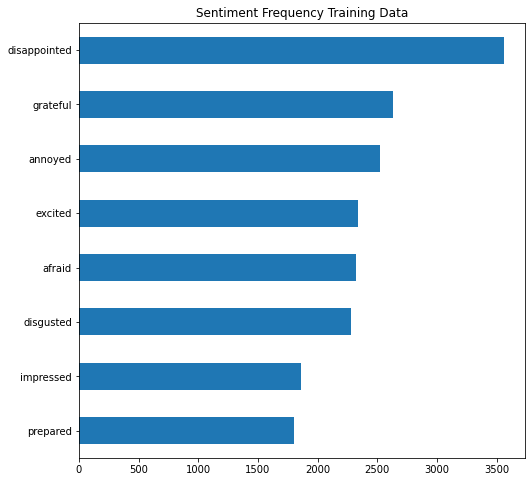

In [ ]:
# updated horizontal bar chart visualizing grouped emotions
train_dataframe.grouped_emotions.value_counts().sort_values().plot(kind = 'barh', linewidth=20, figsize = [8,8], title='Sentiment Frequency Training Data')

In [ ]:
# for validation data
# load valid csv file
splitname = "valid"
path = '/content/empatheticdialogues'

# create variable for training dataset
valid_df = open(os.path.join(path, f"{splitname}.csv")).readlines()
print(valid_df[0].strip().split(","))
print(type(valid_df))

['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags']
<class 'list'>


In [ ]:
# load the prompt (message), and context (mood/label) from the valid data into their own arrays
raw_valid_prompt_list = []
raw_valid_context_list = []

for i in range(1, len(valid_df)):
  data_line = valid_df[i].strip().split(",")
  raw_valid_context_list.append(data_line[2])
  raw_valid_prompt_list.append(data_line[3].replace("_comma_", ","))

In [ ]:
# create pandas validation dataframe using arrays
valid_dataframe = pd.DataFrame(columns=['prompt','context'])
valid_dataframe['prompt'] = raw_valid_prompt_list
valid_dataframe['context'] = raw_valid_context_list

In [ ]:
print(f"There are {len(valid_dataframe)} rows in the validation dataset.")

There are 12078 rows in the validation dataset.


In [ ]:
total_duplicate_valid = sum(valid_dataframe[['prompt','context']].duplicated())
print(f"There are {total_duplicate_valid} duplicate prompts (messages) to context (emotion) rows in the validation data.")

There are 9321 duplicate prompts (messages) to context (emotion) rows in the validation data.


In [ ]:
# If we remove duplicates there will be 2757 rows of validation data
12078-9321

2757

In [ ]:
# lets drop duplicate enteries of prompts, context
valid_dataframe = valid_dataframe.drop_duplicates(ignore_index=True)
valid_dataframe.shape

(2757, 2)

In [ ]:
# display random message from validation data frame with accompying sentiment
idx = np.random.randint(valid_dataframe.shape[0])
print('Valid DF row is: ', idx)
print('Message: ', valid_dataframe['prompt'].iloc[idx])
print('Sentiment: ', valid_dataframe['context'].iloc[idx])

Valid DF row is:  237
Message:  I lost someone special long time ago, I felt so gloomy and depressed
Sentiment:  sad


In [ ]:
print(valid_dataframe['context'].value_counts())

surprised       148
annoyed         118
impressed       102
sad             102
excited          97
embarrassed      96
confident        94
lonely           94
prepared         92
disappointed     91
jealous          89
afraid           89
proud            85
joyful           85
angry            84
content          84
nostalgic        83
sentimental      82
anxious          82
disgusted        81
terrified        81
hopeful          81
furious          77
caring           76
devastated       76
anticipating     75
grateful         75
apprehensive     74
trusting         72
guilty           71
ashamed          70
faithful         51
Name: context, dtype: int64


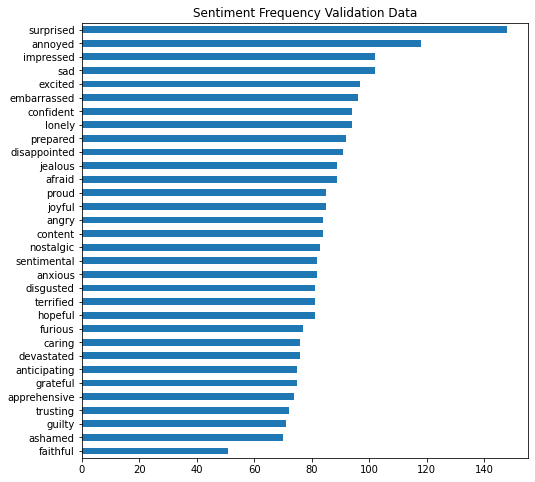

In [ ]:
# visualize value counts of sentiments of validation data using horizontal bar plot 
valid_dataframe.context.value_counts().sort_values().plot(kind = 'barh', linewidth=20, figsize = [8,8], title='Sentiment Frequency Validation Data')

In [ ]:
# we grouped emotions in training data, we need to do the same with validation data
valid_grouped_emotions_col = emotion_grouping(valid_dataframe['context'])

In [ ]:
valid_dataframe['grouped_emotions'] = valid_grouped_emotions_col

In [ ]:
# check side-by-side comparision with original emotions columns and grouped emotions column
valid_dataframe[['context','grouped_emotions']].head(10)

,context,grouped_emotions
0,terrified,afraid
1,surprised,excited
2,excited,excited
3,disgusted,disgusted
4,caring,grateful
5,sentimental,disappointed
6,sad,disappointed
7,embarrassed,disgusted
8,afraid,afraid
9,impressed,impressed


In [ ]:
valid_dataframe['grouped_emotions'].value_counts()

disappointed    528
annoyed         368
grateful        355
excited         330
afraid          326
disgusted       318
impressed       271
prepared        261
Name: grouped_emotions, dtype: int64

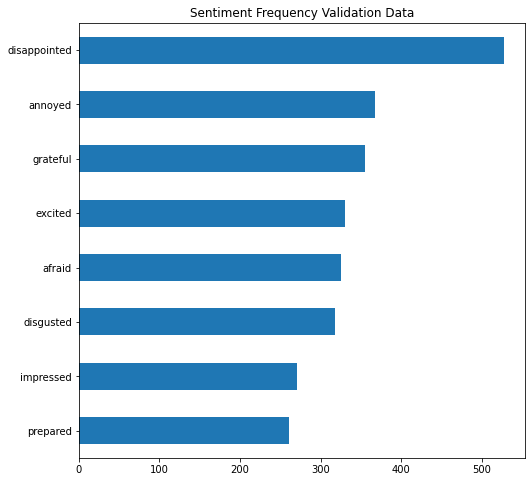

In [ ]:
# updated horizontal bar chart visualizing grouped emotions
valid_dataframe.grouped_emotions.value_counts().sort_values().plot(kind = 'barh', linewidth=20, figsize = [8,8], title='Sentiment Frequency Validation Data')

In [ ]:
# for testing data
# load test csv file 
splitname = "test"
path = '/content/empatheticdialogues'

# create variable for training dataset
test_df = open(os.path.join(path, f"{splitname}.csv")).readlines()
print(test_df[0].strip().split(","))
print(type(test_df))

['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags']
<class 'list'>


In [ ]:
# load the prompt (message), and context (mood/label) from the test data into their own arrays
raw_test_prompt_list = []
raw_test_context_list = []

for i in range(1, len(test_df)):
  data_line = test_df[i].strip().split(",")
  raw_test_context_list.append(data_line[2])
  raw_test_prompt_list.append(data_line[3].replace("_comma_", ","))

In [ ]:
# create pandas dataframe using lists 
test_dataframe = pd.DataFrame(columns=['prompt','context'])
test_dataframe['prompt'] = raw_test_prompt_list
test_dataframe['context'] = raw_test_context_list

In [ ]:
test_dataframe.shape

(10973, 2)

In [ ]:
test_duplicate_valid = sum(test_dataframe[['prompt','context']].duplicated())
print(f"There are {test_duplicate_valid} duplicate prompts (messages) to context (emotion) rows in the test data.")

There are 8430 duplicate prompts (messages) to context (emotion) rows in the test data.


In [ ]:
# If we remove duplicates there will be 2543 rows of test data
# WE WILL NOT REMOVE DUPLICATES FROM TEST DATA

In [ ]:
# group emotions together for tet data using function
test_grouped_emotions_col = emotion_grouping(test_dataframe['context'])

In [ ]:
test_dataframe['grouped_emotions'] = test_grouped_emotions_col

In [ ]:
test_dataframe['grouped_emotions'].shape

(10973,)

In [ ]:
# display random message from test data frame with accompying sentiment
idx = np.random.randint(test_dataframe.shape[0])
print('Test DF row is: ', idx)
print('Message: ', test_dataframe['prompt'].iloc[idx])
print('Sentiment: ', test_dataframe['grouped_emotions'].iloc[idx])

Test DF row is:  3831
Message:  I successfully trained my dog to behave and listen to commands. I had failed with my first dog, but in retrospect it was his breed isnt very trainable.
Sentiment:  impressed


In [ ]:
# data extraction, EDA, cleaning phase complete

We now have the training, validation, and test data extracted, cleaned and formatted into separate pandas dataframes. Next we'll convert the text data 
into numerical vector formats to feed into the model.

In [ ]:
# data vector formatting phase

In [ ]:
# Multi-label binarization preprocessing for target labels
# https://keras.io/examples/nlp/multi_label_classification/

sentiment = tf.ragged.constant(train_dataframe['grouped_emotions'].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(sentiment)
# the sentiment vocabulary added the [UNK] OOV token for unknown values
sentiment_vocab = lookup.get_vocabulary()

# [UNK] token created to cover unknown emotion sentiments
print("Sentiment Vocabulary:\n")
print(sentiment_vocab)

Sentiment Vocabulary:

['[UNK]', 'disappointed', 'grateful', 'annoyed', 'excited', 'afraid', 'disgusted', 'impressed', 'prepared']


In [ ]:
# function to invert multi_hot target labels to string version sentiment

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a string vocab term."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(sentiment_vocab, hot_indices)

In [ ]:
# testing multi_hot labels with the invert function

idx = np.random.randint(test_dataframe.shape[0])
# display original string context label with associated one hot encoded version
sample_label = train_dataframe['grouped_emotions'].iloc[idx]
print(f"Original label: {sample_label}")

# display one hot encoded binary version of target label
label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: disgusted
Label-binarized representation: [0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
batch_size = 128

# function takes a pandas dataframe and returns a tensor.dataset object
# with string targets (messages) and one_hot binary versions of the targets
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["grouped_emotions"].values)
    labels_binarized = [lookup(x).numpy() for x in labels]
    # labels_binarized_tensor = tf.convert_to_tensor(labels_binarized)
    dataset = tf.data.Dataset.from_tensor_slices((dataframe['prompt'].values, labels_binarized))
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
# Now we can prepare the tf.data.Dataset objects. for the training, validation, and test data
train_dataset = make_dataset(train_dataframe, is_train=True)
validation_dataset = make_dataset(valid_dataframe, is_train=False)
test_dataset = make_dataset(test_dataframe, is_train=False)

In [ ]:
# testing the processed training dataset with the inver_multi_hot target function

text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label: {invert_multi_hot(label[0])}")

    print(" ")

Abstract: b'I got a new job!'
Label: ['excited']
 
Abstract: b'I am ashamed I lied to the police.'
Label: ['disgusted']
 
Abstract: b"I was on one of my social media sites and ignored a message from one of my friends who said she really needed someone to go with her to an appointment for her mom so she didn't have to sit by herself in waiting room while her mom was in the back talking with doctor. Come to find out her mom had cancer and my friend just wanted me there for support."
Label: ['disgusted']
 
Abstract: b'I had an exam to write that I was not well prepared for '
Label: ['afraid']
 
Abstract: b'When my friend got a scholarship that I didnt I felt jealous but i felt bad that I was jealous and not as happy for him'
Label: ['disgusted']
 


In [ ]:
# first get percentile estimates for the sequence lenghts of prompts (messages)
train_dataframe["prompt"].apply(lambda x: len(x.split(" "))).describe()

count    19307.000000
mean        18.089398
std         10.190635
min          1.000000
25%         11.000000
50%         16.000000
75%         22.000000
max        114.000000
Name: prompt, dtype: float64

In [ ]:
# take number of samples in training data and divide by the mean sequence length
19307/18 

1072.611111111111

In [ ]:
max_tokens = 20000
max_sequence_length = 18
auto = tf.data.AUTOTUNE

# text vectorization layer for preparing bag of words processing approach
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    ngrams=2,
    output_mode="tf_idf",
)

In [ ]:
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [ ]:
# inspect Dataset objects
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 20000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 20000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [ ]:
# create make model function

def make_model(max_tokens=max_tokens):
  inputs = tf.keras.Input(shape=(max_tokens,))
  x = tf.keras.layers.Dense(90, activation='relu')(inputs)
  x = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
  model = tf.keras.Model(inputs,outputs)

  return model

In [ ]:
# call for simple model 
our_model = make_model()
our_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 90)                1800090   
                                                                 
 dropout (Dropout)           (None, 90)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 819       
                                                                 
Total params: 1,800,909
Trainable params: 1,800,909
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# best simple model: batch size = 128 - 1 Dense layer - 90 filters - relu activation - dropout = 0.5 - custom rmsprop - epochs 15 => 0.6648

opt_rmsprop = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
opt_adam = tf.keras.optimizers.Adam(learning_rate=1e-4)

epochs = 20

our_model.compile(optimizer=opt_rmsprop, loss ='categorical_crossentropy', metrics=['categorical_accuracy'])

history = our_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/20
151/151 [==============================] - 4s 8ms/step - loss: 2.0948 - categorical_accuracy: 0.2271 - val_loss: 1.9088 - val_categorical_accuracy: 0.3663
Epoch 2/20
151/151 [==============================] - 1s 7ms/step - loss: 1.7703 - categorical_accuracy: 0.4197 - val_loss: 1.6546 - val_categorical_accuracy: 0.4908
Epoch 3/20
151/151 [==============================] - 1s 7ms/step - loss: 1.4948 - categorical_accuracy: 0.5431 - val_loss: 1.4496 - val_categorical_accuracy: 0.5608
Epoch 4/20
151/151 [==============================] - 1s 7ms/step - loss: 1.2854 - categorical_accuracy: 0.6121 - val_loss: 1.3201 - val_categorical_accuracy: 0.5948
Epoch 5/20
151/151 [==============================] - 1s 7ms/step - loss: 1.1382 - categorical_accuracy: 0.6611 - val_loss: 1.2308 - val_categorical_accuracy: 0.6159
Epoch 6/20
151/151 [==============================] - 1s 7ms/step - loss: 1.0206 - categorical_accuracy: 0.6967 - val_loss: 1.1688 - val_categorical_accuracy: 0.6337
Epoc

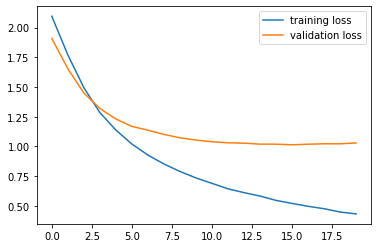

In [ ]:
# visualize the loss during training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label = 'training loss')
plt.plot(val_loss, label = 'validation loss')
plt.legend()

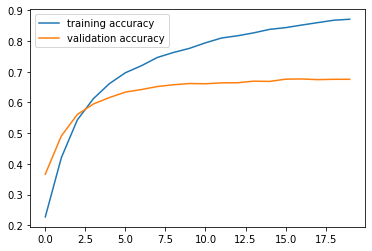

In [ ]:
# visualize the accuracy during training
train_accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
plt.plot(train_accuracy, label='training accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.legend()

In [ ]:
_, categorical_acc = our_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

86/86 [==============================] - 0s 5ms/step - loss: 1.1299 - categorical_accuracy: 0.6470
Categorical accuracy on the test set: 64.7%.


# Inference

In [ ]:
model_for_inference = keras.Sequential([text_vectorizer, our_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_dataframe.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

In [ ]:
# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    predicted_label = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:1]
    print(f"Predicted Label(s): ({', '.join([label for label in predicted_label])})")
    print(" ")

Abstract: b"Some random guy was in my backyard, I didn't realize before I looked outside that I was missing pants. Turns out he was the cable guy fixing a wire."
Label(s): ['disgusted']
Predicted Label(s): (disgusted)
 
Abstract: b"I'm always doing things to take care of the future"
Label(s): ['prepared']
Predicted Label(s): (grateful)
 
Abstract: b'I recently went to the pool. I lost my swim trunks and felt awkward!'
Label(s): ['disgusted']
Predicted Label(s): (disgusted)
 
Abstract: b'While in college, I was in the running for a scholarship. Despite being fully qualified to receive it and meeting the criteria, it was given to someone else. I really wanted that scholarship.'
Label(s): ['annoyed']
Predicted Label(s): (disappointed)
 
Abstract: b'A dog chased me down the streets last night.. i was shaking by the time i escaped'
Label(s): ['afraid']
Predicted Label(s): (afraid)
 
